# Libraries

In [2]:
import numpy as np
import numpy.random as rnd
import numpy.linalg
import matplotlib.pyplot as plt
from numpy import linalg as LA
from numpy.random import normal
import scipy
from scipy.spatial.transform import Rotation as R
from pathlib import Path
import os

In [18]:


class Configuration:
    #This is the class used to do the simulation
    
    def __init__(self,Nx,Ny, J,directory,seed_control=False,seed=1500,preload=False,oldconfig=0):
        #we create a kagome lattice from parameter a and theta with Nx*Ny*3 spins
        # for this we define a few global variables 
        self.a,self.theta,self.Nx,self.Ny,self.J=1,2*np.pi/3,Nx,Ny,J,
        self.N=Nx*Ny*3

        # a_1 and a_2 are the generating vectors for the kagome lattice
        a_1=self.a*np.array([1,0])
        a_2=self.a*np.array([-1*np.cos(self.theta),np.sin(self.theta)])
        
        # we construct the unit cell
        unit_cell=np.array([[0,0],0.5*a_2,0.5*a_1])
        
        # we construct the grid points from the translations of the lattice
        self.x_l,self.y_l=np.meshgrid(range(Nx),range(Ny))
        A_1=np.tensordot(self.y_l,[a_1,a_1,a_1],axes=0)
        A_2=np.tensordot(self.x_l,[a_2,a_2,a_2],axes=0)

        # the lattice points coordinates are created from adding a unit cell at each grid point
        self.lattice=np.tensordot(np.ones((Nx,Ny)),unit_cell,axes=0)+A_1+A_2

        # we create a dim object containing the dimensions of the lattice 
        dim=self.lattice.shape

        #seed control for when we want to test with the same starting configuration
        if seed_control==True:
            np.random.seed(seed) 

        # then we create a random spin configuration  self.config as a 3d vector on each grid point
        self.config=2*np.random.rand(dim[0],dim[1],dim[2],3)-1*np.ones((dim[0],dim[1],dim[2],3))

        # we normalize to get unit vectors at each grid points
        Norm=np.repeat(LA.norm(self.config,axis=3)[:, :,:, np.newaxis], 3, axis=3)
        self.config/=Norm
        
        # if we want to start from a previous simulation config we can pass it in the parameters
        if preload==True:
            self.config=oldconfig

        # we want to save some value while the simulation runs for post processing
        # especially The energy , the acceptation rate, the temperature and heat capacity
        self.Energy=[self.total_energy()]
        self.acceptation_rates=[]
        self.Temperatures=[]
        self.Capa=[]


        #we create a directory to dump simulations results
        cwd = Path.cwd()
        parent = cwd.parent
        #current_dir = os.getcwd()
        
        relative_path = 'Results/'+str(directory)

        full_path = os.path.join(parent, relative_path)
        
        if not os.path.exists(full_path):
            os.mkdir(full_path)
        self.full_path=full_path
        

    def get_mean_field(self):
        #This part of the code adds the spins of the neighbors at lattice point
        #this creates a vector which is very usefull get energy contribution 
        # and do overelaxation fast

        # we create the (self.Nx,self.Ny, 3,3) tensor

        self.mean_field=np.zeros(self.config.shape)

        # we add the fields from the two other points on a triangle
        self.mean_field[:,:,0,:]=self.config[:,:,1,:]+self.config[:,:,2,:]
        self.mean_field[:,:,1,:]=self.config[:,:,2,:]+self.config[:,:,0,:]
        self.mean_field[:,:,2,:]=self.config[:,:,0,:]+self.config[:,:,1,:]


        #self.mean_field[:,:,0,:]+= np.roll(self.config[:,:,1,:],(0,-1),axis=(0,1)).copy()+np.roll(self.config[:,:,2,:],(-1,0),axis=(0,1)).copy()
        #self.mean_field[:,:,1,:]+=np.roll(self.config[:,:,2,:],(-1,1),axis=(0,1)).copy()+np.roll(self.config[:,:,0,:],(0,1),axis=(0,1)).copy()
        #self.mean_field[:,:,2,:]+=np.roll(self.config[:,:,0,:],(1,0),axis=(0,1)).copy()+np.roll(self.config[:,:,1,:],(1,-1),axis=(0,1)).copy()

        #then we add the spins of two neighboring points
        self.mean_field[:,:,0,:]+= np.roll(self.config[:,:,1,:],(0,1),axis=(0,1)).copy()+np.roll(self.config[:,:,2,:],(1,0),axis=(0,1)).copy()
        self.mean_field[:,:,1,:]+=np.roll(self.config[:,:,2,:],(1,-1),axis=(0,1)).copy()+np.roll(self.config[:,:,0,:],(0,-1),axis=(0,1)).copy()
        self.mean_field[:,:,2,:]+=np.roll(self.config[:,:,0,:],(-1,0),axis=(0,1)).copy()+np.roll(self.config[:,:,1,:],(-1,1),axis=(0,1)).copy()
        return self.mean_field
  


    def total_energy(self):
        # the total energy is just a dot product of the vector at each lattice site with 
        #the sum of neighbor's spins of course there is an overcounting factor 
        #that will be taken care of in post processing
        M1=self.get_mean_field()
        M2=self.config
        #the np einsum allows us to deal with the 4 dimensional array efficiently
        E=self.J*np.sum(np.einsum('ijkl,ijkl->ijk', M1, M2))

        return E





    def delta_energy(self):
        # this function is used to compute the energy difference for each 
        # lattice point this is very usefull to do the MC step 
        # at the same time on the whole lattice
        M1=self.get_mean_field()

        #we use the difference between the new and old spins
        M2=self.flipped_spin-self.config
        
        #the energy change at each lattice site is calculated with a dot product
        C=np.einsum('ijkl,ijkl->ijk', M1, M2)


        #we do not forget the J factor
        Delta_E=(self.J)*C
    
        return Delta_E


    def overrelaxation_2(self,dose=0.1):
        #In this part we implement Nf iterrations of overrelaxation
      

        t1 = timeit.default_timer()
        # we select the number Nf of sites that will be rotated
        Nf=int(round(dose*self.N))
        pick = np.zeros(self.N)
        pick[:Nf-1]=1
        np.random.shuffle(pick)
        pick=np.reshape(pick,(self.Nx,self.Ny,3))
        newpick=np.repeat(pick[:, :,:, np.newaxis], 3, axis=3)
        
        newpick=newpick.astype(bool)
        #print(self.config)
        #print(self.total_energy())
        B=self.get_mean_field()
        Norm=np.repeat(np.sqrt(np.einsum('...i,...i',B, B))[:, :,:, np.newaxis], 3, axis=3)
        B/=Norm
        

        dotproduct=np.einsum('ijkl,ijkl->ijk', B, self.config)

        #print(dotproduct.max(),dotproduct.min())
        #dotproduct=np.sqrt(np.abs(dotproduct)) * np.sign(dotproduct)
        newdotproduct=np.repeat(dotproduct[:, :,:, np.newaxis], 3, axis=3)
        #normal=self.config-newdotproduct*B


        #newarr=(2*newdotproduct)*B-self.config
        # #newarr=self.config-2*normal
        newarr=self.config-2*(self.config-newdotproduct*B)




        self.config=np.where(newpick,newarr,self.config )
        t2 = timeit.default_timer()
        
        return t2-t1

    def overrelaxation(self,dose=0.1):
        '''In this part we implement Nf iterrations of overrelaxation'''
      

        Nf=int(round(dose*self.N))
        pick=np.concatenate((np.ones(Nf),np.zeros(self.N-Nf)))
        np.random.shuffle(pick)
        pick=np.reshape(pick,(self.Nx,self.Ny,3))
        pick=pick.astype(bool)
        newpick=np.repeat(pick[:, :,:, np.newaxis], 3, axis=3)    


        B=self.get_mean_field()

        angle=np.pi
        Rot=np.zeros((self.Nx,self.Ny,3,4))
        Rot[:,:,:,0]=np.cos(angle/2)
        Rot[:,:,:,1:]=np.sin(angle/2)*B
        Norm=np.repeat(LA.norm(Rot,axis=3)[:, :,:, np.newaxis], 4, axis=3)
        Rot/=Norm
        Rotad=np.reshape(Rot,(self.N,4),order='C').copy()
        r = R.from_quat(Rotad,scalar_first=True)
        newarr=r.apply(  np.reshape(self.config,(self.N,3),order='C').copy())



        self.config=np.where(newpick,np.reshape(newarr,(self.Nx,self.Ny,3,3),order='C') ,self.config )




    def Monte_Carlo(self,Nf,T,measure_capa=False,overrelaxation=False,overrelaxation_dose=0.1):
        #'''In this part we implement the Nf monte carlo steps
        #here with the metropolis move'''

        Ener=[]
        beta=1/T

        for comp in range(Nf):

            

                    
            n = np.random.normal(0,(np.sqrt(T),np.sqrt(T),np.sqrt(T)),(self.Nx,self.Ny,3,3))
            self.flipped_spin=self.config+n
            Norm=np.repeat(np.sqrt(np.einsum('...i,...i', self.flipped_spin, self.flipped_spin))[:, :,:, np.newaxis], 3, axis=3)
            self.flipped_spin/=Norm
            

            delta=self.delta_energy()


            proba=np.random.rand(self.Nx,self.Ny,3)
            expener=np.exp(-beta*delta)
            decision=np.where(proba< expener)


            newproba = np.repeat(proba[:, :,:, np.newaxis], 3, axis=3)
            newexpener= np.repeat(expener[:, :,:, np.newaxis], 3, axis=3)
            self.config=np.where(newproba<= newexpener,self.flipped_spin,self.config)


            flag=len(decision[0])

            if overrelaxation==True:

                self.overrelaxation_2(overrelaxation_dose)


            if comp%100==0 and measure_capa==True:
                Ener.append(self.total_energy())
                #print(self.total_energy())
                self.acceptation_rates.append(flag/self.N)
                #print(flag/self.N,T)
                
                
        if measure_capa==True:
            Capacite=np.var(Ener)/(T**2)
            self.Capa.append(Capacite)
            self.Energy=np.concatenate((self.Energy,Ener))
            self.Temperatures.append(T*np.ones(len(Ener)))






    def verify_norm(self):
        """ we have sometimes a problem with the  spin vectors not 
        being normalised after too many rotations due to errors so we normalise them after each 
        flip and we verify their maximum norms"""
        print('maximumspinsnorm=',LA.norm(self.config,axis=3).max())
        print('maximumrotatedvectornorm=',LA.norm(self.flipped_spin,axis=3).max())

    def saveconfig(self,name,T):
        # code for saving the spin configuration with parameters
        mydict={
        "Temperature": T,
        "Nx": self.Nx,
        "Ny": self.Ny,
        "J": self.J,
        "N":self.N,
        "lattice":np.array(self.lattice),
        "configuration":np.array(self.config),
        "Energy":np.array(self.Energy),
        "acceptation_rate":np.array(self.acceptation_rates)  ,
        "Capacité":np.array(self.Capa)  ,
        'Temperatures':self.Temperatures,
        }
        #np.save(title+'infos',[T,self.Nx,self.Ny,J,self.N])
        title= os.path.join(self.full_path, name)
        np.save(title, mydict)



# Benchmarking


6
7
8
9
10
11
12
13
14
15
16
17


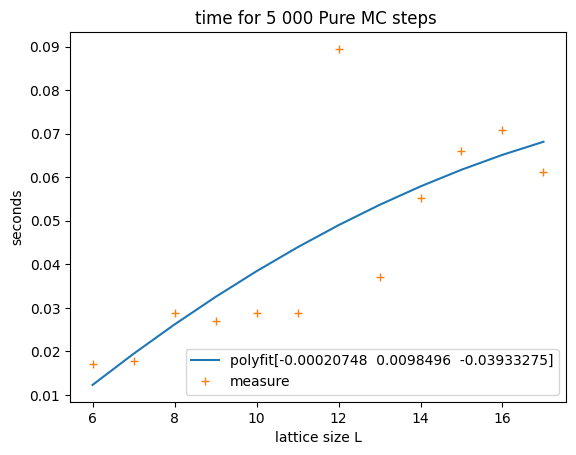

[-0.00020748  0.0098496  -0.03933275]
maximumspinsnorm= 1.0000000000000002
maximumrotatedvectornorm= 1.0000000000000002


In [7]:
import timeit
J=1
Ntemp=50
L=5
Nx=L
Ny=L

N=Nx*Ny*3
Temp=np.power(10*np.ones(Ntemp),np.linspace(-0.1,-4,Ntemp))
#print(Temp)
#initialise simulation




Length=range(6,18)
Times=[]
for L in Length:
    numberMC=5000
    A=Configuration(L,L, 1,'AAAP')
    
    
    #t1 = timeit.default_timer()
    a=str(A.Monte_Carlo(numberMC,0.01,measure_capa=False,overrelaxation=False,overrelaxation_dose=0.1))
    
    #t2 = timeit.default_timer()
    Times.append(timeit.timeit(a))
    print(L)


x = Length
y = Times
p30 = np.poly1d(np.polyfit(x, y, 2))
f=np.polyfit(x, y, 2)
plt.plot(x,p30(x),label='polyfit'+str(f))

plt.plot(x,y,'+',label='measure')  # Log x-axis only
plt.xlabel('lattice size L')
plt.ylabel('seconds')
plt.title('time for 5 000 Pure MC steps ')
plt.legend(loc='best')
plt.show()

print(np.polyfit(x, y, 2))
A.verify_norm()

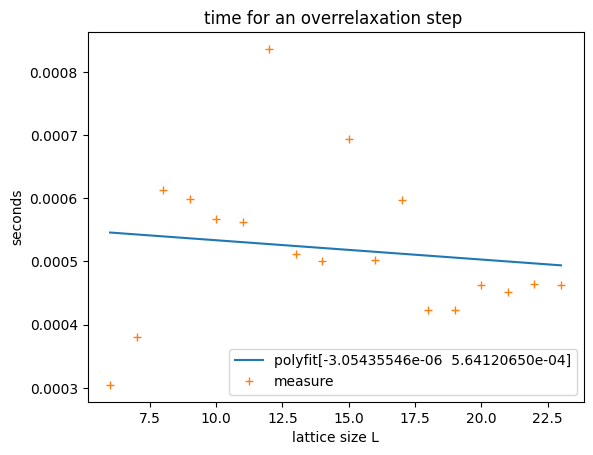

[-2.71461853e-06  7.56695818e-05  6.64405871e-05]


In [28]:




Length=range(6,24)
Times=[]
for L in Length:
    numberMC=50000
    A=Configuration(L,L, 1,'AAAP')
    
    
    t1 = timeit.default_timer()

    t=A.overrelaxation_2(0.1)
    t2 = timeit.default_timer()
    Times.append(t)


x = Length
y = Times
p30 = np.poly1d(np.polyfit(x, y, 1))
f=np.polyfit(x, y, 1)
plt.plot(x,p30(x),label='polyfit'+str(f))

plt.plot(x,y,'+',label='measure')  # Log x-axis only
plt.xlabel('lattice size L')
plt.ylabel('seconds')
plt.title('time for an overrelaxation step ')
plt.legend(loc='best')
plt.show()

print(np.polyfit(x, y, 2))

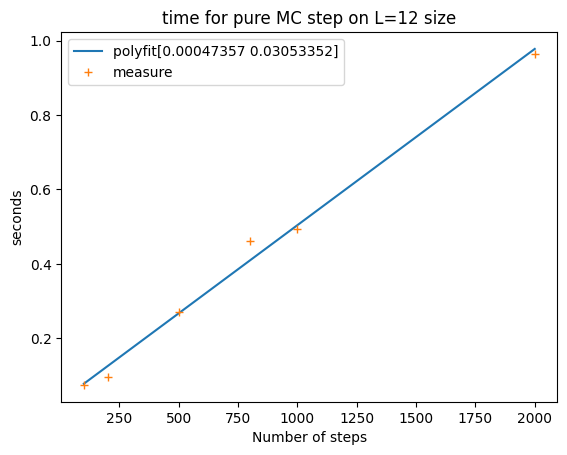

[-3.78063779e-08  5.53338708e-04  6.80532274e-03]


In [8]:

steps=[100,200,500,800,1000,2000]
Times=[]
for numberMC in steps:
   # numberMC=10000
    A=Configuration(12,12, 1,'AAAP')
    
    
    t1 = timeit.default_timer()

    A.Monte_Carlo(numberMC,0.1,measure_capa=False,overrelaxation=False,overrelaxation_dose=0.1)
    t2 = timeit.default_timer()
    Times.append(t2-t1)


x = steps
y = Times
p30 = np.poly1d(np.polyfit(x, y,1))
f=np.polyfit(x, y, 1)
plt.plot(x,p30(x),label='polyfit'+str(f))

plt.plot(x,y,'+',label='measure')  # Log x-axis only
plt.xlabel('Number of steps')
plt.ylabel('seconds')
plt.title('time for pure MC step on L=12 size')
plt.legend(loc='best')
plt.show()

print(np.polyfit(x, y, 2))

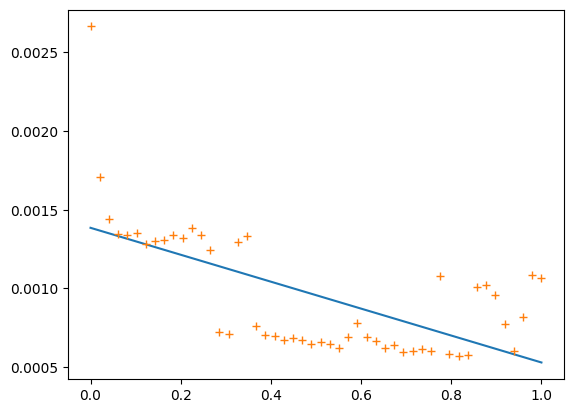

[-0.00085602  0.0013854 ]


In [ ]:
steps=np.linspace(0,1,50)
Times=[]
for numberMC in steps:
   # numberMC=10000
    A=Configuration(12,12, 1,'AAAP')
    
    
    t1 = timeit.default_timer()

    A.overrelaxation(numberMC)
    t2 = timeit.default_timer()
    Times.append(t2-t1)


x = steps
y = Times
p30 = np.poly1d(np.polyfit(x, y, 1))
plt.plot(x,p30(x))

plt.plot(x,y,'+')  # Log x-axis only
plt.show()
print(np.polyfit(x, y, 1))

In [ ]:

#parameters of simulation
J=1
Ntemp=50
L=5
Nx=L
Ny=L

N=Nx*Ny*3
Temp=np.power(10*np.ones(Ntemp),np.linspace(-0.1,-4,Ntemp))
print(Temp)
#initialise simulation
A=Configuration(Nx,Ny, J,'AAAP',seed_control=False,seed=1500)

print(A.total_energy())




for j,T in enumerate(Temp):
    

    decoherencetime=10000
    numberMC=100000
   
    A.Monte_Carlo(decoherencetime,T,measure_capa=False,overrelaxation=False,overrelaxation_dose=0.1)
    A.verify_norm()

    for q in range(5):
        A.Monte_Carlo(numberMC,T,measure_capa=True,overrelaxation=False,overrelaxation_dose=0.1)
        A.verify_norm()

    print(j,'done')


    name=f'simulation{j}'
    
    A.saveconfig(name,T)





[7.94328235e-01 6.61314680e-01 5.50574796e-01 4.58378765e-01
 3.81621341e-01 3.17717266e-01 2.64514193e-01 2.20220195e-01
 1.83343411e-01 1.52641797e-01 1.27081295e-01 1.05801006e-01
 8.80841888e-02 7.33341263e-02 6.10540230e-02 5.08302738e-02
 4.23185338e-02 3.52321199e-02 2.93323554e-02 2.44205309e-02
 2.03312118e-02 1.69266662e-02 1.40922258e-02 1.17324241e-02
 9.76778110e-03 8.13212567e-03 6.77036753e-03 5.63664143e-03
 4.69276246e-03 3.90693994e-03 3.25270665e-03 2.70802744e-03
 2.25455703e-03 1.87702211e-03 1.56270698e-03 1.30102522e-03
 1.08316315e-03 9.01782994e-04 7.50775694e-04 6.25055193e-04
 5.20387110e-04 4.33246132e-04 3.60697272e-04 3.00297019e-04
 2.50011038e-04 2.08145654e-04 1.73290801e-04 1.44272539e-04
 1.20113504e-04 1.00000000e-04]
-12.407473788652238
maximumspinsnorm= 1.0000000000000002
maximumrotatedvectornorm= 1.0000000000000002
maximumspinsnorm= 1.0000000000000002
maximumrotatedvectornorm= 1.0
maximumspinsnorm= 1.0000000000000002
maximumrotatedvectornorm= 1.00